In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv('Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [4]:
X = df.drop('diagnosis', axis=1)
y = pd.DataFrame(df['diagnosis'])

cat_cols = list(X.dtypes[X.dtypes == 'object'].keys())
num_cols = list(X.dtypes[X.dtypes == 'number'].keys())

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
X_train[cat_cols] = X_train[cat_cols].apply(lambda col: col.astype('category'))
X_valid[cat_cols] = X_valid[cat_cols].apply(lambda col: col.astype('category'))

sample_row = X.loc[0].to_dict()

In [5]:
model = LGBMClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(f'accuracy_score: {accuracy_score(y_valid, preds)}')

[LightGBM] [Info] Number of positive: 249, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625628 -> initscore=0.513507
[LightGBM] [Info] Start training from score 0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


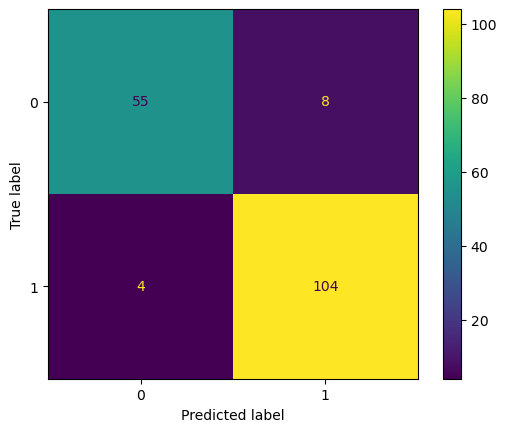

In [6]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

In [8]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [9]:
from pydantic import BaseModel, ValidationError

class Patient(BaseModel):
    mean_radius: float
    mean_texture: float
    mean_perimeter: float
    mean_area: float
    mean_smoothness: float

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print(sample_row)
patient = Patient(**sample_row)
inputs = pd.DataFrame([patient.model_dump()])
pred = loaded_model.predict(inputs)[0]
pred

{'mean_radius': 17.99, 'mean_texture': 10.38, 'mean_perimeter': 122.8, 'mean_area': 1001.0, 'mean_smoothness': 0.1184}


0

In [9]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        patient = Patient(**request.json) 
        inputs = pd.DataFrame([patient.model_dump()])
        pred = loaded_model.predict(inputs)[0]

        response = {
            'prediction': int(pred)
        }

        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
